In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from math import sqrt

np.seterr(over='ignore')

%matplotlib inline 

In [42]:
data_train = pd.read_csv('train.csv', index_col='id')
data_test = pd.read_csv('test.csv', index_col='id')

In [43]:
data_train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
id,,,,,,,
0,02.02.2015,23.7000,26.272,585.200000,749.200000,0.004764,1
1,02.02.2015,23.7180,26.290,578.400000,760.400000,0.004773,1
2,02.02.2015,23.7300,26.230,572.666667,769.666667,0.004765,1
3,02.02.2015,23.7225,26.125,493.750000,774.750000,0.004744,1
4,02.02.2015,23.7540,26.200,488.600000,779.000000,0.004767,1


In [44]:
data_test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio
id,,,,,,
0,12.02.2015,22.315000,26.55,461.50,548.000000,0.004425
1,12.02.2015,22.290000,26.55,454.00,546.250000,0.004418
2,12.02.2015,22.323333,26.60,454.00,542.666667,0.004436
3,12.02.2015,22.290000,26.60,454.00,543.333333,0.004427
4,12.02.2015,22.315000,26.60,450.25,551.750000,0.004433


In [45]:
print(data_train.shape, data_test.shape)

(12336, 7) (8224, 6)


In [46]:
# количество единиц
data_train_count_y1 = data_train[data_train['Occupancy']==1].shape[0]
# количество нулей
data_train_count_y0 = data_train[data_train['Occupancy']==0].shape[0]

print("1 - {}, 0 - {}".format(data_train_count_y1, data_train_count_y0))

1 - 3070, 0 - 9266


In [47]:
data_train_count = data_train.shape[0]
data_train_percent_y1 = data_train_count_y1 / data_train_count
data_train_percent_y0 = data_train_count_y0 / data_train_count
print("Процент единиц - {}, а процент нулей - {}."\
      .format(round(data_train_percent_y1*100,2),\
              round(data_train_percent_y0*100,2)))

Процент единиц - 24.89, а процент нулей - 75.11.


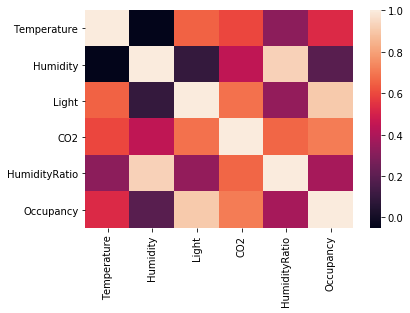

In [48]:
sns.heatmap(data_train.corr())

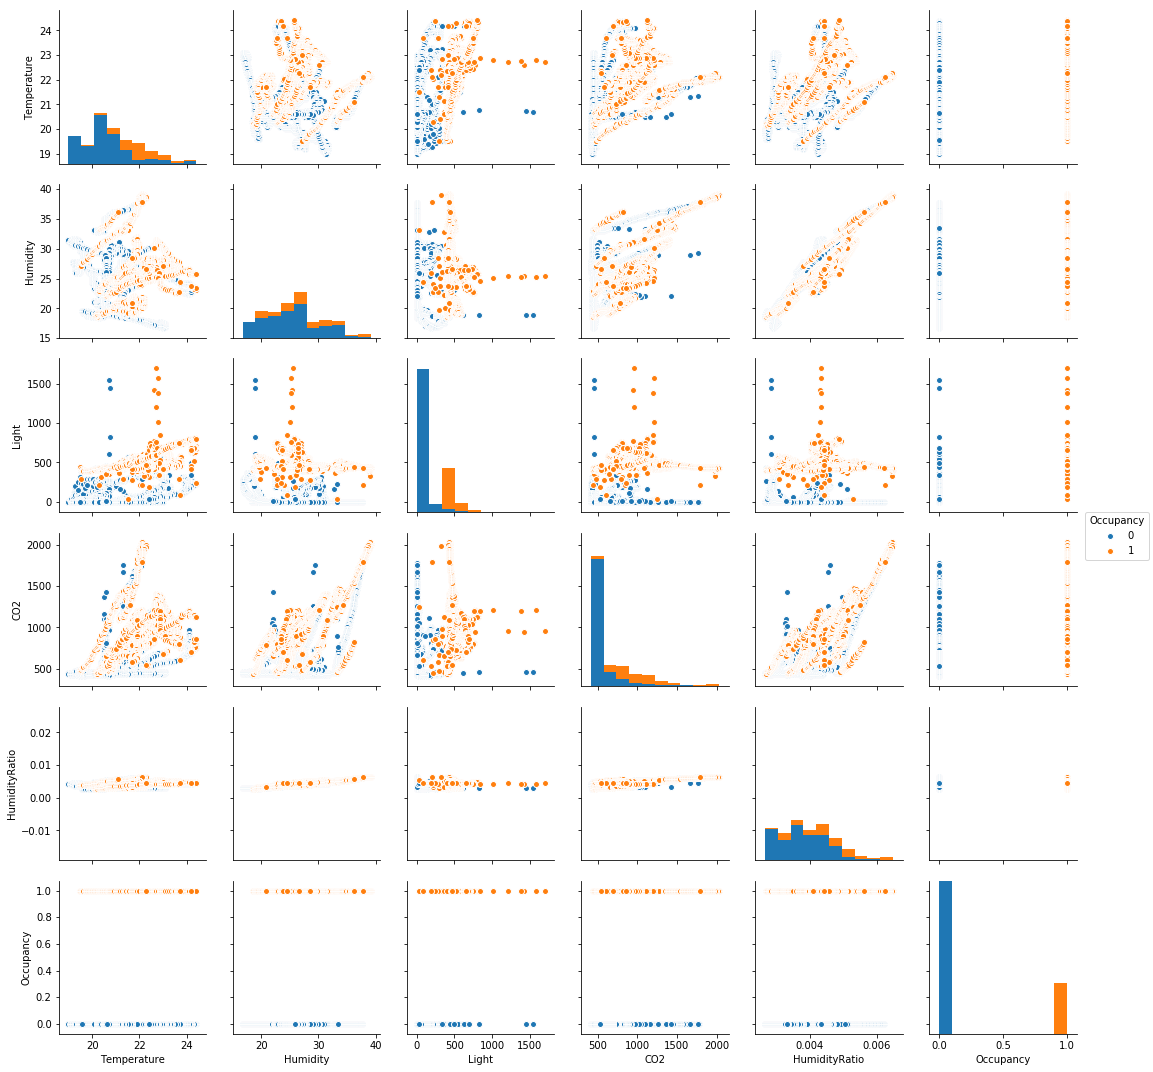

In [49]:
sns.pairplot(data_train, hue="Occupancy")

In [50]:
data_train.columns[data_train.isnull().values.any()].tolist()

[]

In [51]:
# используем предварительно отобранные признаки
cols_x = ['Temperature', 'Light', 'CO2', 'Humidity']   
# целевой признак
col_y = 'Occupancy'

X_train, X_test, y_train, y_test = train_test_split(data_train[cols_x], data_train[col_y], test_size=0.2)

In [52]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
accuracy_score(y_test, lr.predict(X_test))

0.9902755267423015

In [54]:
def sigmoid(res): #он же логистическая функция
    return 1 / (1 + np.exp(-res))

In [55]:
def log_likelihood(X, y, W): # логарифмическая функция правдоподобия
    res = np.dot(X, W)
    ll = np.sum(y*res - np.log(1 + np.exp(res)) )
    return ll

In [84]:
class MyLogisticRegression:
    def __init__(self, steps, alpha, add_intercept = True, decreasing_alpha = False):
        self.steps = steps
        self.alpha = alpha
        self.add_intercept = add_intercept
        self.decreasing_alpha = decreasing_alpha
        
    def fit(self, X, y):
        if self.add_intercept: #В - добавляем к матрице X
            intercept = np.ones((X.shape[0], 1))
            X = np.hstack((intercept, X))

        self.weights = np.random.uniform(-30000,10000,X.shape[1])
        print(self.weights)

        for step in range(self.steps):
            scores = np.dot(X, self.weights)
            predictions = sigmoid(scores)

            error = y - predictions
            gradient = np.dot(X.T, error) #считаем градиент
            
            if self.decreasing_alpha:
                self.weights += self.alpha/sqrt(step+1) * gradient
            else:
                self.weights += self.alpha * gradient
    
    def predict_binary(self, X): #есть или нет
        if self.add_intercept:
            intercept = np.ones((X.shape[0], 1))
            X = np.hstack((intercept, X))
            
        res =  np.sign(np.dot(X, self.weights))   
        np.place(res, res < 0, 0)
        return res
    
    def predict(self, X): #вероятность
        if self.add_intercept:
            intercept = np.ones((X.shape[0], 1))
            X = np.hstack((intercept, X))
        return sigmoid(np.dot(X, self.weights))

In [93]:
my_lr = MyLogisticRegression(40000, 0.005)
my_lr.fit(X_train, y_train)

[-11884.30017155 -23953.34993503 -26304.93958626  -1313.44580316
 -26902.91165967]


ПОДБОР ПАРАМЕТРОВ
alphas = [0.1, 0.05, 0.02, 0.01, 0.005]
steps = [1000, 5000, 10000, 20000, 40000, 80000]

for alpha in alphas:
    for step in steps:
        print('alpha =', alpha, ', step = ', step, 'deacreasing = True')
        my_lr = MyLogisticRegression(step, alpha, True, True)
        my_lr.fit(X_train, y_train)
        print(accuracy_score(y_test, my_lr.predict_binary(X_test)))
        
        print('deacrecing = False')
        my_lr = MyLogisticRegression(step, alpha, True, False)
        my_lr.fit(X_train, y_train)
        print(accuracy_score(y_test, my_lr.predict_binary(X_test)))
        print()

In [100]:
my_predict = my_lr.predict_binary(X_test)

In [109]:
print(accuracy_score(y_test, my_predict))

0.9898703403565641


In [116]:
print(my_predict)
len(my_predict)

[0. 0. 1. ... 0. 0. 1.]


2468

In [104]:
print(my_lr.weights)

[ -18329.36232933 -175618.07407907    8813.6635428      688.82180192
   -3353.25135762]


In [117]:
data_test

,date,Temperature,Humidity,Light,CO2,HumidityRatio
id,,,,,,
0,12.02.2015,22.315000,26.550000,461.500000,548.000000,0.004425
1,12.02.2015,22.290000,26.550000,454.000000,546.250000,0.004418
2,12.02.2015,22.323333,26.600000,454.000000,542.666667,0.004436
3,12.02.2015,22.290000,26.600000,454.000000,543.333333,0.004427
4,12.02.2015,22.315000,26.600000,450.250000,551.750000,0.004433
5,12.02.2015,22.290000,26.650000,439.000000,555.000000,0.004435
6,12.02.2015,22.290000,26.650000,439.000000,552.750000,0.004435
7,12.02.2015,22.290000,26.745000,439.000000,555.000000,0.004451
8,12.02.2015,22.290000,26.790000,439.000000,554.000000,0.004458


In [122]:
print(my_lr.predict_binary(data_test[cols_x]))
len(my_lr.predict_binary(data_test[cols_x]))

[1. 1. 1. ... 1. 1. 1.]


8224

In [139]:
ans=pd.concat([data_test, pd.DataFrame(my_lr.predict_binary(data_test[cols_x]))], axis=1)

In [148]:
ans1=ans.rename({ans.columns[6]: 'value'}, axis=1)

In [149]:
print(ans1)

            date  Temperature   Humidity       Light          CO2  \
id                                                                  
0     12.02.2015    22.315000  26.550000  461.500000   548.000000   
1     12.02.2015    22.290000  26.550000  454.000000   546.250000   
2     12.02.2015    22.323333  26.600000  454.000000   542.666667   
3     12.02.2015    22.290000  26.600000  454.000000   543.333333   
4     12.02.2015    22.315000  26.600000  450.250000   551.750000   
5     12.02.2015    22.290000  26.650000  439.000000   555.000000   
6     12.02.2015    22.290000  26.650000  439.000000   552.750000   
7     12.02.2015    22.290000  26.745000  439.000000   555.000000   
8     12.02.2015    22.290000  26.790000  439.000000   554.000000   
9     12.02.2015    22.290000  26.815000  439.000000   556.500000   
10    12.02.2015    22.290000  26.790000  439.000000   565.000000   
11    12.02.2015    22.267500  26.865000  439.000000   561.750000   
12    12.02.2015    22.267500  26.

In [151]:
ans1.to_csv("submission.csv", index=True)